# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [49]:
# Библиотека для работы с матрицами
import numpy as np 

import scipy as sp

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [3]:
L1 = np.array([[1, 0], [10 ** 20, 1]])
U1 = np.array([[10 ** -20, 1], [0, 1 - (10 ** 20)]])

L2 = np.array([[1., 0], [10 ** 20, 1.]])
U2 = np.array([[10 ** -20, 1.], [0, 1. - (10 ** 20)]])

print("int: ", L1.dot(U1), sep='\n')
print("double: ", L2.dot(U2), sep='\n')

int: 
[[1e-20 1]
 [1.0 1]]
double: 
[[1e-20 1.0]
 [1.0 0.0]]


**Ответ: **При работе с целочисленным типом все операции производятся точно (до тех пор пока помещаются в отведенное ограничение). При работе с числами в формате с плавающей точкой учитывем, что они представляются в виде мантиссы, основания и порядка. число $10^{20}$ достаточно велико, чтобы мантиссы $10^{20}$ и $10^{20} - 1$ совпадали. В таком случае получаем что их разность равняется 0

Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

Теперь проверьте, что будет, если вычислить QR-разложение исходной матрицы и перемножить матрицы $Q$ и $R$.

In [13]:
A = np.array([[10 ** -20, 1.], [1., 1.]])

Q, R = sla.qr(A)

print("Q =\n {},\nR =\n {},\nA =\n {}".format(Q, R, Q.dot(R)))

Q =
 [[ 0. -1.]
 [-1.  0.]],
R =
 [[-1. -1.]
 [ 0. -1.]],
A =
 [[ 0.  1.]
 [ 1.  1.]]


**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$

Но что, если это отношение велико?

**Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [19]:
size = 500
A = np.zeros([size, size])

for i in range(size):
    for j in range(i):
        A[i][j] = -1
    A[i][i] = 1
    A[i][size-1] = 1
    
print(A)

P, L, U = sla.lu(A)
Q, R = sla.qr(A)

assert(np.array_equal(P, np.identity(size)))

print("la-residual: ", sla.norm(A - L.dot(U)))
print("qr-residual: ", sla.norm(A - Q.dot(R)))

p = np.amax(U) / np.amax(A)
print("p:", p)

[[ 1.  0.  0. ...,  0.  0.  1.]
 [-1.  1.  0. ...,  0.  0.  1.]
 [-1. -1.  1. ...,  0.  0.  1.]
 ..., 
 [-1. -1. -1. ...,  1.  0.  1.]
 [-1. -1. -1. ..., -1.  1.  1.]
 [-1. -1. -1. ..., -1. -1.  1.]]
la-residual:  3.10251707042e+116
qr-residual:  1.22937714278e-12
p: 1.63669530395e+150


К счастью, на практике так редко бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

**Ответ: **Воспользуемся известным равенством: $\sum_{j = 0}^k\binom{m}{j}\binom{n-m}{k-j} = \binom{n}{k}$. При подставлении $j = k, n = i + j, k = i, m = j$ получим $\sum_{k = 0}^{i}\binom{j}{k}\binom{i}{i - k} = \binom{i + j}{i} = \sum_{k = 0}^{i}\binom{j}{k}\binom{i}{k}$, что является значением $ij$-го элемента матрицы $A$. Таким образом, $k$-й элемент $i$-й строки матрицы $L$ будет представлять собой $\binom{i}{k}$, а $k$-й элемент $j$-го столбца матрицы $U$ $\binom{j}{k}$. Нетрудно видеть, что диагональные элементы обеих матриц (они, кстати нижняя и верхняя треугольные) равны $1$, а значит и определители $= 1$, а путем несложных математических преобразований получим: $det A = det(LU) = detL \times detU = 1$

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [61]:
def my_pascal(size):
    A = np.empty([size, size])
    for i in range(size):
        A[0][i] = 1
        A[i][0] = 1
    for i in range(size-1):
        for j in range(size-1):
            A[i+1][j+1] = A[i][j+1] + A[i+1][j]
    return A

A = my_pascal(30)

P, L, U = sla.lu(A)

print("norm: ", sla.norm(A - (P.dot(L)).dot(U)))

norm:  17.5241909414


Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [62]:
print(sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x)
x1 = sla.solve(A, b)
print(sla.norm(x1 - x))

3.347360253314365e+49
82761800.69880882


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [64]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print(sla.norm(x2 - x))

543417472.6483039


Объясните полученные неприятные результаты.

In [65]:
print("Condition number = {}".format(sla.norm(A) * sla.norm(sla.inv(A))))

Condition number = 6.543215829347474e+24


**Объяснение: **Нетрудно видеть, что число невероятно велико, так что даже маленькие погрешности вызывают большие изменения ответа.

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [67]:
def naive_solve(A, b):
    return sla.inv(A).dot(b)

def standard_solve(A, b):
    return sla.solve(A, b)

def cholesky_decomposition_solve(A, b):
    L = sla.cholesky(A, lower = True)
    y = sla.solve_triangular(L, b, lower = True)
    return sla.solve_triangular(L.T, y)

def advanced_cholesky_solve(A, b):
    return sla.cho_solve(sla.cho_factor(A), b)

Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [83]:
def test(A, b, real_x):
    naive_r = sla.norm(real_x - naive_solve(A, b))
    standard_r = sla.norm(real_x - standard_solve(A, b))
    cholesky_r = sla.norm(real_x - cholesky_decomposition_solve(A, b))
    ad_cholesky_r = sla.norm(real_x - advanced_cholesky_solve(A, b))
    return (naive_r, standard_r, cholesky_r, ad_cholesky_r)

def generate_random_system(size, rhs_number = 1):
    x = 100 * np.random.random_sample((size, rhs_number)) - 50
    A = 100 * np.random.random_sample((size, size)) - 50
    A = A.T.dot(A) # for ensuring that A > 0 and symmetric
    b = A.dot(x)
    return (A, b, x)

A, b, x = generate_random_system(10)

print(test(A, b, x))

(7.6328601011589381e-13, 5.4774083580459329e-13, 1.2467509607540005e-12, 9.8178880163868187e-13)


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

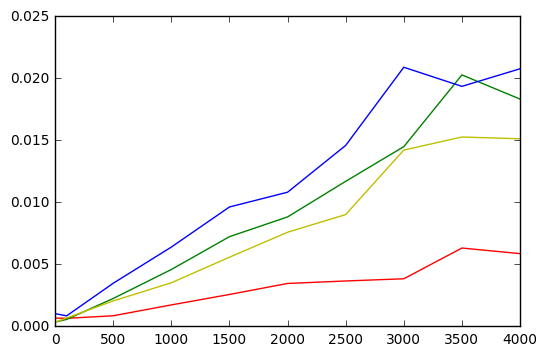

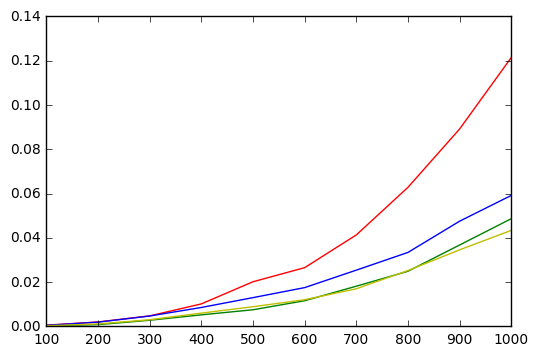

In [242]:
import time

functions = [naive_solve, standard_solve, cholesky_decomposition_solve, advanced_cholesky_solve]

def fixed_number_test():
    sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    times = [[], [], [], []]
    colors = ['r', 'g', 'b', 'y']
    for size in sizes:
        A, b, x = generate_random_system(size)
        for i in range(len(functions)):
            start = time.clock()
            #res = %timeit -o functions[i](A, b)
            #times[i].append(res.best)
            for j in range(100):
                functions[i](A, b)
            times[i].append((time.clock() - start)/100.)
    for i in range(len(times)):
        plt.plot(sizes, times[i], colors[i])
    plt.show()
    
def fixed_size_test():
    size = 200
    numbers = [1, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    times = [[], [], [], []]
    colors = ['r', 'g', 'b', 'y']
    for number in numbers:
        A, b, x = generate_random_system(100, number)
        for i in range(len(functions)):
            start = time.clock()
            #res = %timeit -o functions[i](A, b)
            #times[i].append(res.best)
            for j in range(100):
                functions[i](A, b)
            times[i].append((time.clock() - start)/100.)
    for i in range(len(times)):
        plt.plot(numbers, times[i], colors[i])
    plt.show()
    
fixed_size_test()
plt.clf()
fixed_number_test()

*Если фиксировать размер матрицы А (первая картинка), то наивный способ является самым предпочтительным. Библиотечный Холецкий на втором месте, а остальные два варианта не сильно рознятся. Во-втором случае имеем явных лидеров - стандартный и библ. Холецкий. Обращать матрицы больших размеров выглядит глупой идеей.*

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

In [84]:
import math

def my_multivariate_normal_logpdf(X, m, S):
    L = sla.cholesky(S, lower=True)
    detS = 1 
    for i in range(len(S)):
        detS *= L[i][i] ** 2
    D = len(m)
    fract = 1. / ((2 * math.pi) ** (D / 2) * detS ** (1. / 2))
    ln_fract = np.log(fract)
    logpdf = []
    for x in X:
        power = - 1. / 2 * (x - m).T.dot(sla.cho_solve((L, True), (x - m).T))
        logpdf.append(ln_fract + power)
    return logpdf

Сгенерируйте выборку из нормального распределения со случайными параметрами для небольшого $D$ с помощью функции `scipy.stats.multivariate_normal.rvs` и сравните на этой выборке результат работы вашего алгоритма с результатом стандартной функции `scipy.stats.multivariate_normal.logpdf`

In [85]:
from scipy.stats import multivariate_normal

N = 3
D = 3

mean = 100 * np.random.random_sample((D,)) - 50
cov = 100 * np.random.random_sample((D, D)) - 50
cov = cov.T.dot(cov)

scipy_logpdf = []
samples = []
distr = multivariate_normal(mean, cov)
for i in range(N):
    sample = distr.rvs()
    samples.append(sample)
    scipy_logpdf.append(distr.logpdf(sample))

print("Scipy:")
print(scipy_logpdf)
print("Mine:")
print(my_multivariate_normal_logpdf(samples, mean, cov))

Scipy:
[-11.479495945046963, -10.743744821648754, -10.444372918536242]
Mine:
[-11.479495945046919, -10.743744821648844, -10.444372918536219]


Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [95]:
Ds = [10, 50, 100, 200, 300]

setup_code = "from __main__ import X, mean, cov, my_multivariate_normal_logpdf, sp"

for D in Ds:
    print("D =", D)
    mean = (10 * np.random.random_sample((D,)) - 5) / 10.
    cov = (10 * np.random.random_sample((D, D)) - 5) / 10.
    cov = cov.T.dot(cov)
    X = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=10)
    print("Scipy:")
    print(timeit.timeit(stmt = "sp.stats.multivariate_normal.logpdf(X, mean, cov)", setup = setup_code, number = 10))
    print("Mine:")
    print(timeit.timeit(stmt = "my_multivariate_normal_logpdf(X, mean, cov)", setup = setup_code, number = 10))

D = 10
Scipy:
0.0035820313350996003
Mine:
0.008248593658208847
D = 50
Scipy:
0.009329275751952082
Mine:
0.015045729058329016
D = 100
Scipy:
0.025624610294471495
Mine:
0.024540079321013764
D = 200
Scipy:
0.09209532581735402
Mine:
0.09726865832635667
D = 300
Scipy:
0.2303849999443628
Mine:
0.1106833143858239


В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

На больших размерах матриц моя функция хороша! Разложение Холецкого использовалось для нахождения определителя, а вместо обращения решалась система.

## Часть 3. Разреженные матрицы

Матрица называется разреженной, если в ней мало ненулевых элементов.

Например, если в матрице $n\times n$ порядка $O(n)$ ненулевых элементов, она является разреженной.

Зачастую размерность разреженных матриц, возникающих в реальных задачах, так велика, что хранить её в памяти вместе с нулями - непозволительная роскошь. Есть несколько экономичных методов хранения:

- `Dictionary of Keys` (`DOK`) - словарь `(i,j):element`. 

    $\color{green}{\oplus}$ быстрое добавление элементов с произвольными индексами,
  
    $\color{red}{\ominus}$ любые другие операции будут производиться медленно.


- `List of Lists` (`LIL`) - матрица хранится построчно: в виде двух массивов `[l_1,...,l_s]` и `[v_1,...v_s]`, где `l_i` - список номеров столбцов, в которых в i-й строке находится ненулевой элемент, а `v_i` - список соответствующих значений. В целом, подходит для создания в высокой степени разреженной матрицы. Когда все элементы добавлены, лучше перевести в формат `CSR` или `CSC`.

    $\color{green}{\oplus}$ добавление за линейное время, 
    
    $\color{green}{\oplus}$ быстрый доступ к строкам матрицы, 
    
    $\color{red}{\ominus}$ может требовать слишком много памяти (для создания матриц повышенной плотности используйте `COO`).

    
- `Coordinate List` (`COO`) - хранятся тройки `(row, column, value)`  или три массива \texttt{rows,\ columns,\ values}. При этом тройка с одинаковым началом `(row, column)` может быть не одна; при преобразовании к другому типу значения `value` суммируются.

    $\color{green}{\oplus}$ быстрое добавление новых элементов,
    
    $\color{red}{\ominus}$ для всего остального лучше перевести в другой формат.
    
    
- `Compressed Sparse Row/Column storage` (`CSR/CSC`) - разберём на примере `CSR`. Хранятся три массива: `values`, `indptr` и `indices`. В массиве `values` хранятся все ненулевые элементы матрицы, упорядоченные лексикографически по паре (строка, столбец); `indptr[i]` - индекс начала `i`-й строки, `indices[indptr[i]:indptr[i+1]-1]` - номера столбцов соответствующих элементов.

    $\color{green}{\oplus}$ быстрое выполнение арифметических операций,
    
    $\color{green}{\oplus}$ быстрый доступ к строкам для `CSR` и к столбцам для `CSC`,
    
    $\color{red}{\ominus}$ очень медленный доступ к столбцам для `CSR` и к строкам для `CSC`,
    
    $\color{red}{\ominus}$ медленное добавление/удаление элементов.
  

Главный вывод - не надо один и тот же формат использовать для разных целей!

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как эти возможности реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.0** Загрузите файл `sparse_matrix1.mtx`

In [51]:
import scipy.io as sio

In [220]:
A = sio.mmread(r'Downloads\sparse_matrix1.mtx') # Please type right folder name! 

С помощью следующей функции можно посмотреть, как расположены ненулевые элементы матрицы:

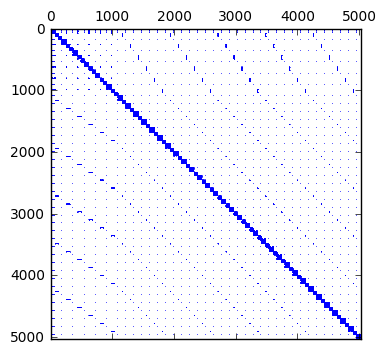

In [221]:
plt.spy(A, marker='.', markersize=0.4)

В каком из пяти форматов хранится матрица? Для ответа на этот вопрос воспользуйтесь функцию `type`.

Сколько в ней ненулевых элементов?

In [222]:
print(type(A))

print("nuber of non-zero elements = ", A.getnnz())

<class 'scipy.sparse.coo.coo_matrix'>
nuber of non-zero elements =  94026


Посмотрим, сколько времени занимает преобразование между разными форматами.

In [224]:
import pandas as pd
import timeit

A_dok = A.todok()
A_lil = A.tolil()
A_csc = A.tocsc()
A_csr = A.tocsr()

conversion_times = pd.DataFrame(
    index=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    columns=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    data={
        'COO': [
            np.nan,
            timeit.timeit('A.todok()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tolil()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsr()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsc()', 'from __main__ import A', number=100) / 100,
               ],
        'DOK': [
            timeit.timeit('A_dok.tocoo()', 'from __main__ import A_dok', number=100) / 100,
            np.nan,
            timeit.timeit('A_dok.tolil()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsr()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsc()', 'from __main__ import A_dok', number=100) / 100,
               ],
        'LIL': [
            timeit.timeit('A_lil.tocoo()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.todok()', 'from __main__ import A_lil', number=100) / 100,
            np.nan,
            timeit.timeit('A_lil.tocsr()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.tocsc()', 'from __main__ import A_lil', number=100) / 100,
               ],
        'CSR': [
            timeit.timeit('A_csr.tocoo()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.todok()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.tolil()', 'from __main__ import A_csr', number=100) / 100,
            np.nan,
            timeit.timeit('A_csr.tocsc()', 'from __main__ import A_csr', number=100) / 100,
               ],
        'CSC': [
            timeit.timeit('A_csc.tocoo()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.todok()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tolil()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tocsr()', 'from __main__ import A_csc', number=100) / 100,
            np.nan,
               ],
    }
    )

conversion_times.T

,COO,DOK,LIL,CSR,CSC
COO,NaN,0.059411,0.021983,0.000863,0.000775
DOK,0.105918,NaN,0.155768,0.129062,0.109195
LIL,0.018858,0.097984,NaN,0.020475,0.023541
CSR,0.002113,0.083176,0.020399,NaN,0.000883
CSC,0.001285,0.074366,0.021435,0.000844,NaN


Как вы можете убедиться, быстрее всего преобразования происходят между форматами `COO`, `CSR` и `CSC`, а хуже всего дела обстоят с форматом `DOK`: все преобразования из него занимают чудовищно много времени.

**Задание 3.1 (0,5 балла)** Почему преобразование из формата `LIL` в формат `CSR` занимает такую пропасть времени?

----
Вообще говоря алгоритм довольно простой. Мы проходимся последовательно по спискам (одноременно и по списку значений, и по списку столбцов) и копируем значения с индексами столбцов. При переходе на новый список записываем значение в indptr. Вся сложность в том, что мы идём одновременно по двум спискам. Из-за этого количество операций выше, чем в более удобных преобразованиях. Ко всему нужно следить за массивом indices. Получаем линейное время для заполнения каждого массива, но в итоге получаем большую константу.

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою список из нескольких сотен тысяч чеков (списков покупок). Для того, чтобы определить, какие товары чаще покупают вместе, вы решили построить матрицу, строки и столбцы которой соответствуют различным товарам (предположим, что число различных товаров тоже измеряется сотнями тысяч), а в клетке с "номером" $(g_1, g_2)$ стоит число

$\log_2{\frac{N\cdot c(g_1 \& g_2)}{c(g_1)c(g_2)}},$

где $c(g_i)$ --- количество чеков, содержащих товар $g_i$, $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара, $N$ --- общее число чеков. В каком формате вы будете создавать эту (очевидно разреженную) матрицу? Почему?

*Первоначально удобно добавлять в COO. Но в клетках писать 1. Тогда получим общее количество, а при переходе в другой формат (например CSR) в клетках получим количество совместных чеков. После этого можно пройти по всем элементам и, учитывая, что мы уже знаем все параметры, то можно пересчитать значение и получить готовую матрицу.*

Напишите максимально эффективный код, создающий эту матрицу:

In [ ]:
def CreateMatrix(receipts):
    row = []
    column = []
    value = []
    counter = 0
    for receipt in receipts:
        for pair in receipt.pairs:
            row.append(pair.first)
            column.append(pair.second)
            value.append(1)
            counter++
    counter /= 2  
    log_N = np.log(counter)
    A = scipy.sparse.coo_matrix((value, (row, column))
    A = A.tocsr()
    for i in range(len(A.indptr)):
        offset = 0
        for j in A.indices[indptr[i]:indptr[i+1]-1]:
            A.data[indptr[i] + offset] = log_N + np.log(A.data[indptr[i] + offset]) 
                                - np.log(A.indptr[i+1]-A.indptr[i]) 
                                - np.log(A.indptr[j+1]-A.indptr[j])

**Задание 3.3 (1 балл)** В каком из форматов `LIL` и `COO` умножение на вектор происходит быстрее? Почему? Проведите эксперименты. Можете воспользоваться функцией `scipy.sparse.random` для создания случайных разреженных матриц.

Насколько быстрее с аналогичной задачей будут справляться форматы `CSC` и `CSR`?

In [47]:
N = 10000
A = scipy.sparse.random(N, N)
b = scipy.random.random(N)
A_lil = A.tolil()
A_coo = A.tocoo()
A_csc = A.tocsc()
A_csr = A.tocsr()
t_lil = timeit.timeit("A_lil * b", "from __main__ import A_lil, b", number=1)
t_coo = timeit.timeit("A_coo * b", "from __main__ import A_coo, b", number=1)
t_csc = timeit.timeit("A_csc * b", "from __main__ import A_csc, b", number=1)
t_csr = timeit.timeit("A_csr * b", "from __main__ import A_csr, b", number=1)
print("LIL: ", t_lil)
print("COO: ", t_coo)
print("CSC: ", t_csc)
print("CSR: ", t_csr)

LIL:  0.16741762739184196
COO:  0.00258773539098911
CSC:  0.12201657758669171
CSR:  0.0016965040977083845


При формате COO просто проходясь по всем тройкам мы можем изменить value каждой умножив на соотвествующий элемент, так как индекс столбца известен. В то же время для LIL обращаемся к каждой строке поочередно, после идем параллельно по двум спискам и перемножаем значение на элемент вектора соответствующего индекса, полученного из второго списка. Вероятно, эти метания забирают драгоценное время.
CSC, конечно, имеет муторный механизм доступа к строкам, поэтому получаем долгое время выполнения. CSR быстрее COO на константу. Из-за возможного наличия дубликатов в COO формате мы неэффективно расходуем время.

## Часть 4. Итерационные методы

В этом задании вам предлагается поработать с итеративными методами решения систем уравнений.

Соответствующие функции реализованы в пакете `scipy.sparse.linalg` (http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.linalg.html). Пожалуйста, читайте документацию перед их применением!

В этом задании вам предстоит поближе познакомиться с двумя итеративными методами:

1. **(L)GMRES** (мы настоятельно рекомендуем использовать оптимизированную функцию `scipy.sparse.linalg.lgmres`, даже если вам нужен обыкновенный **GMRES**)

2. **CG** (вызывается функцией `scipy.sparse.linalg.cg`)

*Замечания*:
1. Функции `scipy.sparse.linalg.lgmres` и `scipy.sparse.linalg.cs` устроены так, что могут решать уравнения только с векторной правой частью.
2. Внимательно ознакомьтесь с параметрами (у функции `scipy.sparse.linalg.lgmres` их очень много) и обратите внимание на формат вывода функций.
3. Вы можете захотеть выводить/сохранять что-нибудь после каждой итерации. Для этого существует параметр `callback`: это функция с сигнатурой `callback(xk)`, вызываемая на каждой итерации. Её аргумент `xk` - это текущее приближение $x_k$. Вот пример вызова функции `lgmres`, печатающей норму текущего приближения:

In [ ]:
x = spla.gmres(A, b, callback=lambda xk: print(sla.norm(xk))

Если вы захотите что-нибудь сохранять по ходу дела, логичнее использовать для этого класс. Ниже приводим пример класса, считающего число итераций и выводящего (если указан флаг `disp`) номер каждой итерации на печать, а также запоминающего все промежуточные приближения (не делайте так для больших систем! вам может не хватить памяти):

In [ ]:
class iterative_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.all_x = [] # Please discard this if you solve large systems!!!
        
    def __call__(self, xk=None):
        self.niter += 1
        self.all_x.append(xk) # Please discard this if you solve large systems!!!
        if self._disp:
            print('iter %3i' % (self.niter))
            
my_counter = gmres_counter() # We need to create an instance of the class

x = spla.gmres(A, b, callback=my_counter)

print(my_counter.niter) # Will print total number of iterations

**Задание 4.1 (3 балла)** Довольно игр! Пора решать большие системы. Загрузите матрицу из файла `large_system.mtx` (она симметричная и положительно определённая) и сгенерируйте случайную правую часть. Решите систему с помощью функции `scipy.sparse.linalg.spsolve` (сильно оптимизированный "точный" решатель) и с помощью итеративных методов `LGMRES` и `CG`. Сравните скорость работы этих методов.

Постарайтесь обогнать функцию `spsolve`, применяя предобуславливание с помощью одной итерации метода Якоби или с помощью неполного LU-разложения. Для ILU постарайтесь подобрать оптимальные значения коэффициентов `fill_factor` и `drop_tol`.

*Замечание.* Если матрица-предобуславливатель $P$ не совсем уж тривиальная, не надо её обращать и умножать на исходную матрицу!

В каждом из итеративных методов можно включить предобуславливание с помощью параметра `M`. В качестве этого параметра нужно передать либо матрицу $P^{-1}$, либо **линейный оператор**, осуществляющий умножение вектора на $P^{-1}$. По понятным причинам второе гораздо правильнее. Делается это следующим образом. Например, если вы хотите ввести предобуславливание с конкретной матрицей $P$ для решения системы $Ax = b$:

In [ ]:
M = spla.LinearOperator(A.shape, lambda x: spla.spsolve(P, x))

x = spla.lgmres(A, b, M=M)

А вот как это работает для неполного LU-разложения:

In [ ]:
my_ILU = spla.spilu(A, '''Add your parameters here''')
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))

x = spla.lgmres(A, b, M=M)

Обратите внимание, что `my_ILU` --- это не просто tuple из четырёх матриц (`spilu` делает разложение вида $P_1AP_2 = LU$, где $P_i$ --- матрицы перестановок). В самом деле, как вы уже, наверное, поняли, в мире больших размерностей иметь матрицу --- это зачастую бесполезное или даже вредное занятие. Гораздо ценнее уметь быстро решать систему с этой матрицей. Поэтому `my_ILU` --- это в первую очередь не разложение (впрочем, матрицы при желании тоже можно извлечь), а оптимизированный решатель `solve`.

In [59]:
A = sio.mmread(r'C:/Users/ш/Downloads/Pres_Poisson.mtx')
A = A.tocsc()
b = np.random.rand(A.shape[0])

In [83]:
my_ILU = spla.spilu(A, drop_tol=10**-6, fill_factor=10)
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))

my_lgmres = timeit.timeit("spla.lgmres(A, b, M=M, tol=10**-12)", "from __main__ import spla, A, b, M", number=1)
my_lgmres_ultra = timeit.timeit("spla.lgmres(A, b, M=M, tol=10**-10)", "from __main__ import spla, A, b, M", number=1)
spsolve = timeit.timeit("spla.spsolve(A, b)", "from __main__ import spla, A, b", number=1)
lgmres = timeit.timeit("spla.lgmres(A, b, tol=10**-5)", "from __main__ import spla, A, b", number=1)
cg = timeit.timeit("spla.cg(A, b, tol=10**-10)", "from __main__ import spla, A, b", number=1)

print("my lgmres execution time: ", my_lgmres) # с применением неполного LU-разложения с эмпирически подобранными параметрами
print("my lgmres execution time (bigger tolerance): ", my_lgmres_ultra) # с применением неполного LU-разложения с эмпирически подобранными параметрами
print("spsolve execution time: ", spsolve)
print("lgmres execution time: ", lgmres)
print("cg execution time: ", cg)

my lgmres execution time:  115.85628168382391
my lgmres execution time (bigger tolerance):  0.24343016277998686
spsolve execution time:  1.1020143366768025
lgmres execution time:  44.729508736534626
cg execution time:  4.8581556644057855


Строго говоря, если нам достаточно 10 знаков точности (а нам прям достаточно), то использование неполного LU-разложения существенно повышает скорость и занимает первое место. Если попросить 12 знаков, то скорость сразу же падает катастрофически. Если не использовать разложение, то lgmres ужасно медленный. Мы попросили подсчитать первые 5 знаков после запятой, а он считал их 40 секунд, ужас.

## Часть 5. Матричные дифференцирования

**Задача 5.1 (1 балл)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

При $i \neq j$:
$$\frac{\partial g}{\partial x_{ij}} = 
\begin{bmatrix}
    0 & \dots & \dots & \dots  & 0 \\
    \vdots & \ddots & \dots & g'_{ij} & \vdots \\
    \vdots & \dots & \ddots & \dots  & \vdots \\
    \vdots & g'_{ji} & \dots & \ddots & \vdots \\
    0 & \dots & \dots & \dots  & 0
\end{bmatrix} =
\begin{bmatrix}
    0 & \dots & \dots & \dots  & 0 \\
    \vdots & \ddots & \dots & f'_{ij} & \vdots \\
    \vdots & \dots & \ddots & \dots  & \vdots \\
    \vdots & f'_{ji} & \dots & \ddots & \vdots \\
    0 & \dots & \dots & \dots  & 0
\end{bmatrix} =
\frac{\partial f}{\partial x_{ij}} + \frac{\partial f}{\partial x_{ji}}$$

При $i = j$:
$$\frac{\partial g}{\partial x_{ii}} = \frac{\partial f}{\partial x_{ii}}$$

Тогда, переписав в матричной форме, как раз получим
$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

**Задача 5.2 (0.5 балла)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

$$
\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial x_{ij}} = 
tr\left(\frac{\partial\mathrm{\left(AX^2BX^{-T}\right)}}{\partial x_{ij}}\right) = 
tr\left(A\frac{\partial{X^2}}{x_{ij}}BX^{-T} + AX^2B\frac{\partial{X^{-T}}}{x_{ij}}\right) = 
tr\left(AX\frac{\partial{X}}{x_{ij}}BX^{-T} + A\frac{\partial{X}}{x_{ij}}XBX^{-T} - AX^2B\left(X^{-1}\frac{\partial{X}}{x_{ij}}X^{-1}\right)^T\right) = 
tr\left(AXE_{ij}BX^{-T} + AE_{ij}XBX^{-T} - AX^2BX^{-T}E_{ji}X^{-T}\right) =
tr\left(BX^{-T}AXE_{ij} + XBX^{-T}AE_{ij} - X^{-T}AX^2BX^{-T}E_{ji}\right) \\\\
\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X} = \\ 
BX^{-T}AX + XBX^{-T}A - (X^{-T}AX^2BX^{-T})^T =
BX^{-T}AX + XBX^{-T}A - X^{-1}B^TX^{2T}A^TX^{-1}
$$

**Задача 5.3 (0.5 балла)** Найдите производную

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

$$
\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial x_{ij}} =
tr\left( \left(X^TAX\right)^{-1} \frac{\partial{\left(X^TAX\right)}}{\partial{x_{ij}}} \right) =
tr\left( \left(X^TAX\right)^{-1} \left(\frac{\partial{\left(X^T\right)}}{\partial{x_{ij}}}AX + 
X^TA\frac{\partial{\left(X\right)}}{\partial{x_{ij}}} \right)\right) = 
tr\left( \left(X^TAX\right)^{-1} \left(E_{ji}AX + X^TAE_{ij} \right)\right) = 
tr\left( AX\left(X^TAX\right)^{-1} E_{ji} + \left(X^TAX\right)^{-1}X^TAE_{ij} \right)\\
\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X} = 
\left(AX\left(X^TAX\right)^{-1}\right)^T + \left(X^TAX\right)^{-1}X^TA = 
\left(X^{-1}A^{-1}X^{-T}\right)^TX^TA^T + X^{-1}A^{-1}X^{-T} X^TA = 
2X^{-1}
$$

**Задача 5.4 (1 балл)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.